# Notebook to run the gaussian regularized alghorithms 

In [114]:


from prob_models.utils.utils import read_paths, getdata

# read_add_paths('paths.txt')
# paths = read_paths('paths.txt')

import prob_models.cov_estim.estimators as es 
import prob_models.cov_estim.run_parallel as run
from prob_models.cov_estim.utils import *
import numpy as np
import os
import importlib
import matplotlib.pyplot as plt
import pickle
import sys

importlib.reload(run)

mod = importlib.reload(sys.modules['prob_models.utils.utils'])#use imp.reload for Python 3  
vars().update(mod.__dict__)

#importlib.reload(prob_models.utils.utils)


In [117]:
# Load data 
paths = read_paths(os.path.join(os.getcwd(), '../paths.txt'))
datadic = getdata(paths,dataset='CamCAN')
T, N = np.shape(list(datadic.values())[0])
print (T,N)


261 114


In [121]:

train_fraction = 0.8
if 'results' not in globals():
    results={}
    TrainTest={}
    
for i,( key, X) in enumerate(datadic.items()):
    if (i<20) & (i not in results):
        print (i)
        # Compute the corr mat C obtained flattening the training data from all patients
        Cbar = computeCbar([el for el in datadic.values()], train_fraction=train_fraction)
        Xtrain, Xtest = split_train_test(X, train_fraction=train_fraction, standardize=True, seed=i)
        TrainTest[key]={'train':Xtrain,'test':Xtest} #save train and test
        key,value=run.single_run(i, Xtrain, Xtest, Cbar=Cbar)
        


        #adding Raw estimator
        J = np.linalg.inv(np.corrcoef(Xtrain.T))
        te_lik=impl.likelihood_set_fast(J, Xtest)    
        tr_lik=impl.likelihood_set_fast(J, Xtrain)
        value['Raw']={'test_likelihood':te_lik,
                      'train_likelihood':tr_lik}
        
        results[key]=value



10
11
12
13
14
15
16
17
18
19


In [122]:
#savefile
filename='../savedfiles/file_TrainTest.pkl'
file = open(filename, "wb")
pickle.dump(TrainTest, file)
file.close()



filename='../savedfiles/file_Gaussianresults.pkl'
file = open(filename, "wb")
pickle.dump(results, file)
file.close()


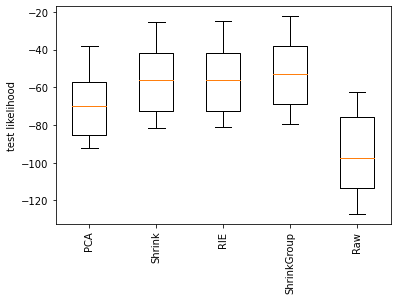

In [123]:
# file = open(filename, "rb")
# results=pickle.load(file)
# file.close()


data={}
results
for subno,sub in results.items():   
    for meth,val in sub.items():
        if meth not in data:
            data[meth]=[]
        data[meth].append(val['test_likelihood'])

#     data[key]=[results[subno]['test_likelihood'] for subno in results.keys()]
# print (data)
labels, data = data.keys(), data.values()
labels=[el.split('_')[0] for el in labels]


plt.boxplot(data)
plt.xticks(range(1, len(labels) + 1), labels,rotation='vertical')
plt.ylabel('test likelihood')
plt.show()

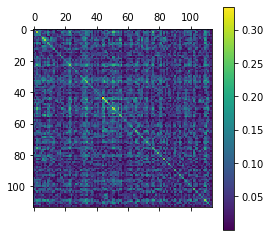

In [146]:
#load gbm results  
i=10
W=np.load('../results/params_'+str(i)+'.npy')
Jeff=W@W.T
plt.matshow(np.abs(Jeff))
plt.colorbar()
plt.show()

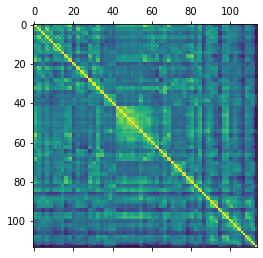

In [139]:
plt.matshow(np.average([el['Shrink_CV_likelihood']['Cclean'] for el in results.values()],axis=0))